In [1]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score
from collections import deque

In [1]:
def cal_clust_silhouette(adata, n_pcs, resolution):
    tmp_adata = sc.pp.neighbors(adata, n_pcs=n_pcs, copy=True)
    sc.tl.umap(tmp_adata)
    sc.tl.leiden(tmp_adata, key_added="leiden_res", resolution=resolution)
    return silhouette_score(tmp_adata.X, tmp_adata.obs['leiden_res'])

In [2]:
def rep_umap_to_ref_ump(adata_rep, adata_ref, batch):
    adata_rep = adata_rep.copy()
    adata_ref = adata_ref.copy()

    rep_index = adata_ref.obs[adata_ref.obs['batch'] == batch].index

    cluster_name = adata_ref.obs.loc[rep_index, 'cluster_name']
    cluster_name.index = cluster_name.index.map(lambda x: '-'.join(x.split('-')[:2]))

    adata_rep.obs['cluster_name'] = cluster_name

    adata_rep.obsm['X_umap_raw'] = adata_rep.obsm['X_umap']

    ref_umap = pd.DataFrame(adata_ref[rep_index, :].obsm['X_umap'], index=rep_index)
    ref_umap.index = ref_umap.index.map(lambda x: '-'.join(x.split('-')[:2]))
    ref_umap = ref_umap.loc[adata_rep.obs_names, :]

    adata_rep.obsm['X_umap'] = ref_umap.values

    return adata_rep.copy()

In [3]:
def umap(adata, ax, marker, cluster):
    sc.pl.umap(
        adata,
        color=marker,
        vmax='p99.8',
        vmin=0,
        frameon=True,
        cmap="Reds",
        colorbar_loc=None,
        title=f'{cluster} ({marker})',
        ax=ax, show=False
    )

    ax.arrow(
        -6.5, -3, 0, 3, 
        width=0.01, head_width=0.2, overhang=0.3, 
        color='k', zorder=10)
    ax.arrow(
        -6.5, -3, 3, 0, 
        width=0.01, head_width=0.2, overhang=0.3,
        color='k', zorder=10)

    ax.text(-3.1, -3, 'UMAP-1', ha='left', va='center', fontsize=8)
    ax.text(-6.5, 0.8, 'UMAP-2', ha='center', va='bottom', rotation=90, fontsize=8)

    ax.set_xlabel('')
    ax.set_ylabel('')

    return ax

In [4]:
def violin(adata, ax, marker):
    sc.pl.violin(
        adata,
        marker,
        groupby='leiden_res',
        ax=ax, show=False
    )

    ax.set_xlabel('')

    ax.yaxis.set_label_position("right")
    ax.set_ylabel(' Expression')
    ax.tick_params(axis='y', right=True)
    sns.despine(top=True, bottom=True, left=True, right=False, trim=1, ax=ax)

    return ax

In [6]:
def plot_umap_violin_rep(adata, marker, cluster):

    import matplotlib.pyplot as plt
    import seaborn as sns

    fig = plt.figure(figsize=(8, 3))

    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)

    ax1 = umap(
        adata, ax1,
        marker, cluster
    )

    ax2 = violin(
        adata, ax2, marker
    )

    plt.subplots_adjust(
        hspace=0.3, wspace=0.01)

# read data

In [2]:
# read in data
rep1 = sc.read('../scdata_rep1/1.QC.h5ad')
rep2 = sc.read('../scdata_rep2/1.QC.h5ad')
# check var name
var_names = rep1.var_names.intersection(rep2.var_names)
rep1 = rep1[:, var_names]
rep2 = rep2[:, var_names]

len(var_names)
# concat adata
adata_merge = rep1.concatenate(rep2, batch_categories=["rep1", "rep2"])

adata_merge

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/merge.py:1015: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  concat_

AnnData object with n_obs × n_vars = 7147 × 19804
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-rep1', 'mean_counts-rep1', 'pct_dropout_by_counts-rep1', 'total_counts-rep1', 'n_cells_by_counts-rep2', 'mean_counts-rep2', 'pct_dropout_by_counts-rep2', 'total_counts-rep2'

# cluster1

In [3]:
cluster1_df = pd.read_csv('../merge_rep/4.cluster1.csv', index_col=0)
cluster1_df

,n_genes_by_counts,total_counts,pct_counts_in_top_100_genes,total_counts_mt,pct_counts_mt,batch,leiden_res
AAACCCACACCTGTCT-1-rep1,191,611.0,85.106383,181.0,29.623568,rep1,1
AAACGAATCGGCGATC-1-rep1,2285,20453.0,73.304650,439.0,2.146384,rep1,1
AAAGGGCGTCATCGCG-1-rep1,300,1268.0,82.176656,192.0,15.141956,rep1,1
AAAGGTAGTTAAACAG-1-rep1,1279,15570.0,82.389210,615.0,3.949904,rep1,1
AAAGGTAGTTAAGGGC-1-rep1,1014,7176.0,79.250279,1059.0,14.757525,rep1,1
...,...,...,...,...,...,...,...
TTCCTAAGTACACGTT-1-rep2,2303,18890.0,70.206458,291.0,1.540498,rep2,1
TTCCTCTGTCAGGAGT-1-rep2,2419,21541.0,74.021633,376.0,1.745509,rep2,1
TTGCCTGCACACTTAG-1-rep2,2426,14792.0,63.230124,530.0,3.583018,rep2,1
TTTCATGGTTAACCTG-1-rep2,917,2348.0,45.102215,57.0,2.427598,rep2,1


In [4]:
adata = adata_merge[adata_merge.obs.index.isin(cluster1_df.index)]
adata

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


View of AnnData object with n_obs × n_vars = 850 × 19804
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-rep1', 'mean_counts-rep1', 'pct_dropout_by_counts-rep1', 'total_counts-rep1', 'n_cells_by_counts-rep2', 'mean_counts-rep2', 'pct_dropout_by_counts-rep2', 'total_counts-rep2'

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-pack

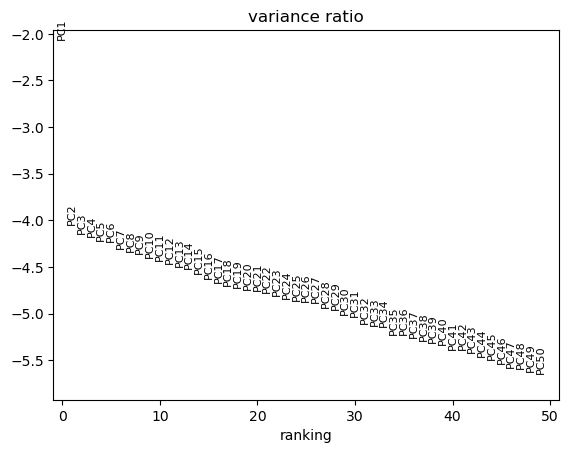

In [5]:
# -----------------------------------------------------------------------
# normalization 
sc.pp.normalize_total(adata)
# Logarithmize
sc.pp.log1p(adata)
# find highly variable genes
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor='seurat_v3')
# save original AnnData to `.raw` attribute
adata.raw = adata
# only keeping highly variable genes in AnnData
adata = adata[:, adata.var.highly_variable]
# scale each gene to unit variance
sc.pp.scale(adata)
# -----------------------------------------------------------------------
# run PCA
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
# run harmonoy
sce.pp.harmony_integrate(adata, 'batch')

adata.obsm['X_pca_raw'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
# -----------------------------------------------------------------------
# plot single PCs to the total variance in the data
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

## arguments selection

In [61]:
args_res = deque()
all_pcs = np.linspace(7, 15, 9).astype(int)
all_reses = np.linspace(0.1, 0.9, 5)

count = 0
total_process = len(all_pcs) * len(all_reses)
for pcs in all_pcs:
    for res in all_reses:
        count += 1

        sil = cal_clust_silhouette(adata, pcs, res)
        args_res.append([pcs, res, sil])

        if count % 3 == 0:
            print(f'Processing {count}/{total_process}')
        
args_res_df = pd.DataFrame(args_res, columns=['n_pcs', 'resolution', 'silhouette_score'])

Processing 3/45
Processing 6/45
Processing 9/45
Processing 12/45
Processing 15/45
Processing 18/45
Processing 21/45
Processing 24/45
Processing 27/45
Processing 30/45
Processing 33/45
Processing 36/45
Processing 39/45
Processing 42/45
Processing 45/45


In [18]:
best_args = args_res_df[args_res_df['silhouette_score'] == args_res_df['silhouette_score'].max()]
best_args

,n_pcs,resolution,silhouette_score
35,14,0.1,-0.038986


In [ ]:
args_res_df.to_csv('./1.cluster1.arg_select.csv', index=False)

In [17]:
args_res_df = pd.read_csv('./1.cluster1.arg_select.csv')
args_res_df

,n_pcs,resolution,silhouette_score
0,7,0.1,-0.043531
1,7,0.3,-0.168889
2,7,0.5,-0.162616
3,7,0.7,-0.174108
4,7,0.9,-0.168349
5,8,0.1,-0.043548
6,8,0.3,-0.168838
7,8,0.5,-0.166643
8,8,0.7,-0.165810
9,8,0.9,-0.165591


/tmp/ipykernel_8017/944085384.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  adata = sc.pp.neighbors(adata, n_pcs=int(best_args['n_pcs']), copy=True)
/tmp/ipykernel_8017/944085384.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sc.tl.leiden(adata, key_added="leiden_res", resolution=float(best_args['resolution']))
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_a

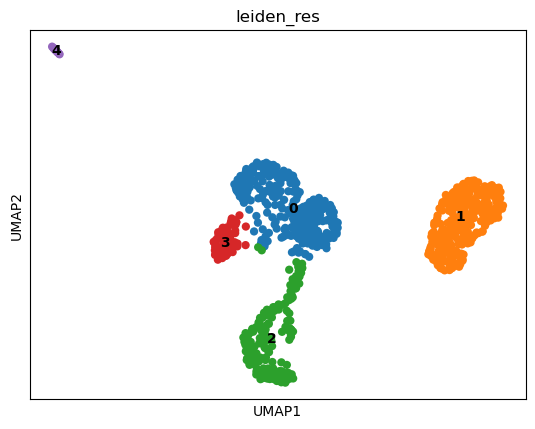

In [23]:
# plot PCA
adata = sc.pp.neighbors(adata, n_pcs=int(best_args['n_pcs']), copy=True)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_res", resolution=float(best_args['resolution']))

sc.pl.umap(
    adata,
    color=["leiden_res"],
    legend_loc="on data",
)

In [10]:
marker_genes = {
    'ISC/EB': ['AAEL013544', 'AAEL025606'], # Klu, Delta
    'FBC': ['AAEL008789'], # apoLp-III 'https://www.science.org/doi/10.1126/science.abc0322#supplementary-materials' (table s5)
}

In [8]:
adata = sc.read('./1.cluster1.Annotation.h5ad')

Only considering the two last: ['.Annotation', '.h5ad'].
Only considering the two last: ['.Annotation', '.h5ad'].


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/categorical.py:641: F

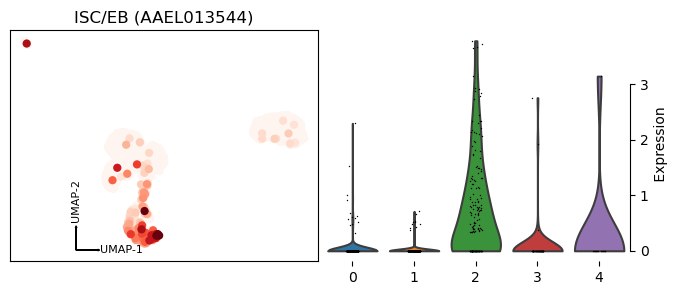

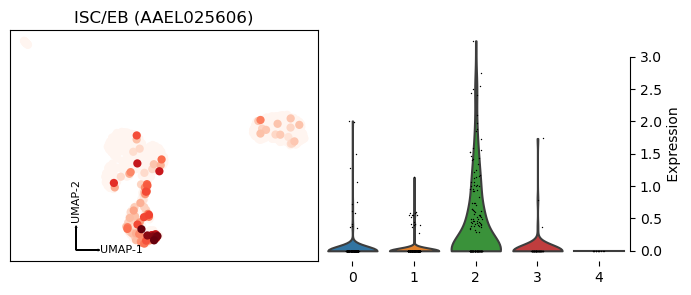

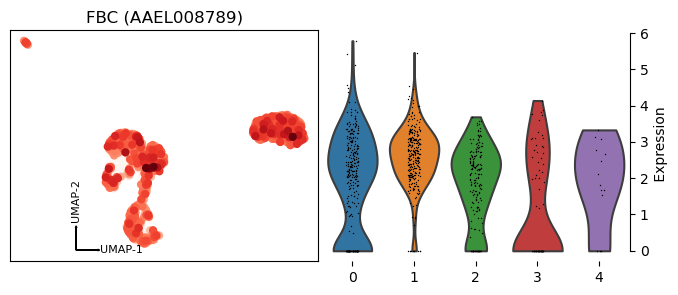

In [11]:
def plot_umap_violin_rep(adata, marker, cluster):

    import matplotlib.pyplot as plt
    import seaborn as sns

    fig = plt.figure(figsize=(8, 3))

    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    sc.pl.umap(
        adata,
        color=marker,
        vmax='p99.8',
        vmin=0,
        frameon=True,
        cmap="Reds",
        colorbar_loc=None,
        title=f'{cluster} ({marker})',
        ax=ax1, show=False
    )

    ax1.arrow(
        -6.5, -3, 0, 3, 
        width=0.01, head_width=0.2, overhang=0.3, 
        color='k', zorder=10)
    ax1.arrow(
        -6.5, -3, 3, 0, 
        width=0.01, head_width=0.2, overhang=0.3,
        color='k', zorder=10)

    ax1.text(-3.1, -3, 'UMAP-1', ha='left', va='center', fontsize=8)
    ax1.text(-6.5, 0.8, 'UMAP-2', ha='center', va='bottom', rotation=90, fontsize=8)

    # ax1.set_title('')
    ax1.set_xlabel('')
    ax1.set_ylabel('')

    # ax1.set_xlim(-7.5, 21)
    # ax1.set_ylim(-3.6, 16)

    sc.pl.violin(
        adata,
        marker,
        groupby='leiden_res',
        ax=ax2, show=False
    )

    ax2.set_xlabel('')

    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel(' Expression')
    ax2.tick_params(axis='y', right=True)
    sns.despine(top=True, bottom=True, left=True, right=False, trim=1, ax=ax2)

    # plot title
    # ax1.plot((-6.5, 50), (19,19), '-k', clip_on=False, zorder=100)
    # ax1.text((-6.5 + 50) / 2, 19.2, f'{cluster} ({marker})', ha='center', va='bottom')

    plt.subplots_adjust(
        hspace=0.3, wspace=0.01)

for cluster in marker_genes.keys():
    for marker in marker_genes[cluster]:

        plot_umap_violin_rep(
            adata, marker, cluster, 
        )

In [68]:
# save data
adata.write("1.cluster1.Annotation.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 850 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden_res'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-rep1', 'mean_counts-rep1', 'pct_dropout_by_counts-rep1', 'total_counts-rep1', 'n_cells_by_counts-rep2', 'mean_counts-rep2', 'pct_dropout_by_counts-rep2', 'total_counts-rep2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_res_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# cluster2

In [21]:
cluster2_df = pd.read_csv('../merge_rep/4.cluster2.csv', index_col=0)
cluster2_df

,n_genes_by_counts,total_counts,pct_counts_in_top_100_genes,total_counts_mt,pct_counts_mt,batch,leiden_res
AAGATAGAGTCTTCCC-1-rep1,280,691.0,73.950796,174.0,25.180897,rep1,2
AAGTGAATCCAAATGC-1-rep1,307,740.0,72.027027,186.0,25.135136,rep1,2
AATAGAGCATTCAGCA-1-rep1,2487,10890.0,48.503214,680.0,6.244261,rep1,2
AATCACGCAAGCGAAC-1-rep1,261,654.0,75.382263,125.0,19.113150,rep1,2
AATGACCAGCCTCAAT-1-rep1,2192,9043.0,47.793874,377.0,4.168971,rep1,2
...,...,...,...,...,...,...,...
TTGTTGTGTCGGCACT-1-rep2,1446,3657.0,38.720263,142.0,3.882964,rep2,2
TTGTTTGCACTATGTG-1-rep2,1595,14830.0,77.120701,3429.0,23.122050,rep2,2
TTGTTTGCAGCGTTGC-1-rep2,575,2639.0,76.809397,194.0,7.351270,rep2,2
TTTAGTCCAATCGCAT-1-rep2,2475,7791.0,33.846746,81.0,1.039661,rep2,2


In [22]:
adata = adata_merge[adata_merge.obs.index.isin(cluster2_df.index)]
adata

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


View of AnnData object with n_obs × n_vars = 314 × 19804
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-rep1', 'mean_counts-rep1', 'pct_dropout_by_counts-rep1', 'total_counts-rep1', 'n_cells_by_counts-rep2', 'mean_counts-rep2', 'pct_dropout_by_counts-rep2', 'total_counts-rep2'

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-pack

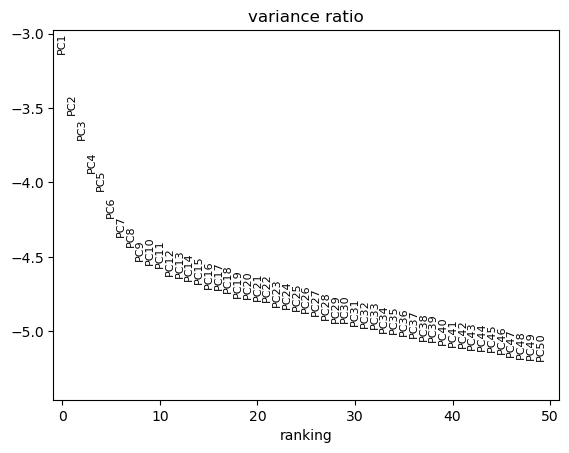

In [23]:
# -----------------------------------------------------------------------
# normalization 
sc.pp.normalize_total(adata)
# Logarithmize
sc.pp.log1p(adata)
# find highly variable genes
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor='seurat_v3')
# save original AnnData to `.raw` attribute
adata.raw = adata
# only keeping highly variable genes in AnnData
adata = adata[:, adata.var.highly_variable]
# scale each gene to unit variance
sc.pp.scale(adata)
# -----------------------------------------------------------------------
# run PCA
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
# run harmonoy
sce.pp.harmony_integrate(adata, 'batch')

adata.obsm['X_pca_raw'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
# -----------------------------------------------------------------------
# plot single PCs to the total variance in the data
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

## arguments selection

In [24]:
args_res = deque()
all_pcs = np.linspace(10, 19, 10).astype(int)
all_reses = np.linspace(0.1, 0.9, 5)

count = 0
total_process = len(all_pcs) * len(all_reses)
for pcs in all_pcs:
    for res in all_reses:
        count += 1

        sil = cal_clust_silhouette(adata, pcs, res)
        args_res.append([pcs, res, sil])

        if count % 3 == 0:
            print(f'Processing {count}/{total_process}')
        
args_res_df = pd.DataFrame(args_res, columns=['n_pcs', 'resolution', 'silhouette_score'])

Processing 3/50
Processing 6/50
Processing 9/50
Processing 12/50
Processing 15/50
Processing 18/50
Processing 21/50
Processing 24/50
Processing 27/50
Processing 30/50
Processing 33/50
Processing 36/50
Processing 39/50
Processing 42/50
Processing 45/50
Processing 48/50


In [25]:
best_args = args_res_df[args_res_df['silhouette_score'] == args_res_df['silhouette_score'].max()]
best_args

,n_pcs,resolution,silhouette_score
13,12,0.7,-0.034483


In [26]:
args_res_df.to_csv('./2.cluster2.arg_select.csv', index=False)

/tmp/ipykernel_107019/944085384.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  adata = sc.pp.neighbors(adata, n_pcs=int(best_args['n_pcs']), copy=True)
/tmp/ipykernel_107019/944085384.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sc.tl.leiden(adata, key_added="leiden_res", resolution=float(best_args['resolution']))
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `

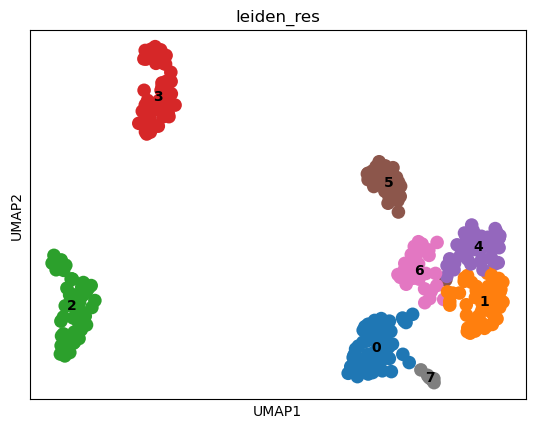

In [27]:
# plot PCA
adata = sc.pp.neighbors(adata, n_pcs=int(best_args['n_pcs']), copy=True)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_res", resolution=float(best_args['resolution']))

sc.pl.umap(
    adata,
    color=["leiden_res"],
    legend_loc="on data",
)

In [18]:
marker_genes = {
    'EC': ['AAEL017445'], # Nubbin
    'EE': ['AAEL002769', 'AAEL002733'], # prospero, NPF
}

In [13]:
adata = sc.read('./2.cluster2.Annotation.h5ad')

Only considering the two last: ['.Annotation', '.h5ad'].
Only considering the two last: ['.Annotation', '.h5ad'].


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/categorical.py:641: F

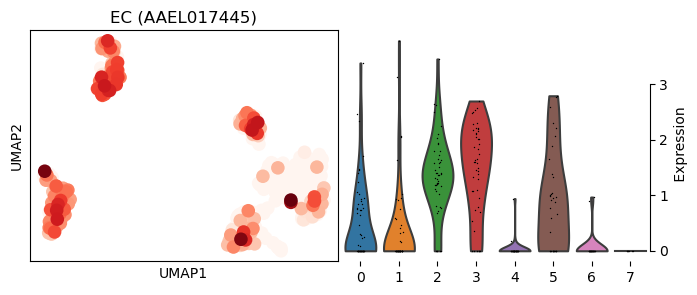

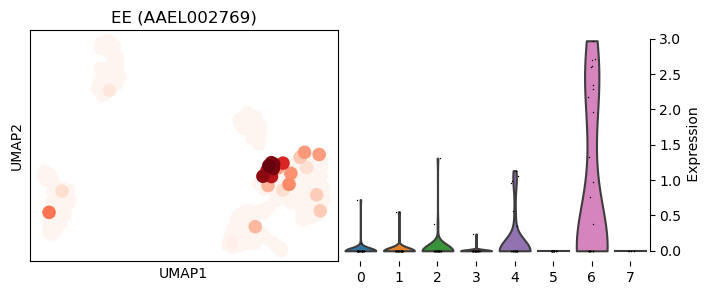

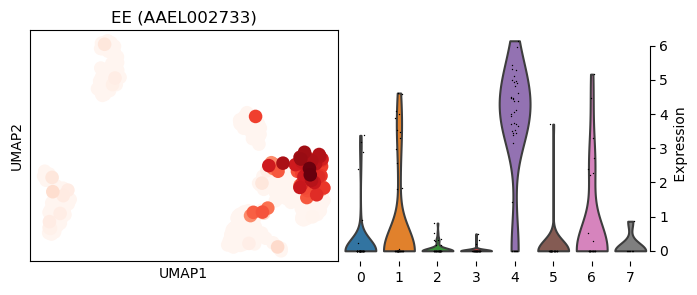

In [19]:
def plot_umap_violin_rep(adata, marker, cluster):

    import matplotlib.pyplot as plt
    import seaborn as sns

    fig = plt.figure(figsize=(8, 3))

    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    sc.pl.umap(
        adata,
        color=marker,
        vmax='p99.8',
        vmin=0,
        frameon=True,
        cmap="Reds",
        colorbar_loc=None,
        title=f'{cluster} ({marker})',
        ax=ax1, show=False
    )

    # ax1.arrow(
    #     -6.5, -3, 0, 3, 
    #     width=0.01, head_width=0.2, overhang=0.3, 
    #     color='k', zorder=10)
    # ax1.arrow(
    #     -6.5, -3, 3, 0, 
    #     width=0.01, head_width=0.2, overhang=0.3,
    #     color='k', zorder=10)

    # ax1.text(-3.1, -3, 'UMAP-1', ha='left', va='center', fontsize=8)
    # ax1.text(-6.5, 0.8, 'UMAP-2', ha='center', va='bottom', rotation=90, fontsize=8)

    # ax1.set_title('')
    # ax1.set_xlabel('')
    # ax1.set_ylabel('')

    # ax1.set_xlim(-7.5, 21)
    # ax1.set_ylim(-3.6, 16)

    sc.pl.violin(
        adata,
        marker,
        groupby='leiden_res',
        ax=ax2, show=False
    )

    ax2.set_xlabel('')

    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel(' Expression')
    ax2.tick_params(axis='y', right=True)
    sns.despine(top=True, bottom=True, left=True, right=False, trim=1, ax=ax2)

    # plot title
    # ax1.plot((-6.5, 50), (19,19), '-k', clip_on=False, zorder=100)
    # ax1.text((-6.5 + 50) / 2, 19.2, f'{cluster} ({marker})', ha='center', va='bottom')

    plt.subplots_adjust(
        hspace=0.3, wspace=0.01)

for cluster in marker_genes.keys():
    for marker in marker_genes[cluster]:

        plot_umap_violin_rep(
            adata, marker, cluster, 
        )

In [32]:
# save data
adata.write("2.cluster2.Annotation.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 314 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden_res'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-rep1', 'mean_counts-rep1', 'pct_dropout_by_counts-rep1', 'total_counts-rep1', 'n_cells_by_counts-rep2', 'mean_counts-rep2', 'pct_dropout_by_counts-rep2', 'total_counts-rep2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_res_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# cluster3

In [33]:
cluster3_df = pd.read_csv('../merge_rep/4.cluster3.csv', index_col=0)
cluster3_df

,n_genes_by_counts,total_counts,pct_counts_in_top_100_genes,total_counts_mt,pct_counts_mt,batch,leiden_res
AAACCCATCGCTCTAC-1-rep1,1443,6541.0,55.496102,406.0,6.207002,rep1,3
AAAGGGCTCAAACCCA-1-rep1,1073,8204.0,72.696246,553.0,6.740614,rep1,3
AAATGGATCCATGCAA-1-rep1,377,1332.0,76.201201,355.0,26.651651,rep1,3
AACCAACAGAGTCCGA-1-rep1,293,1145.0,83.144105,289.0,25.240173,rep1,3
AACGGGACAGGTTCAT-1-rep1,164,579.0,88.946459,106.0,18.307426,rep1,3
...,...,...,...,...,...,...,...
TGTTGGAGTCGAATGG-1-rep2,414,1144.0,68.706294,63.0,5.506993,rep2,3
TGTTTGTGTCCAAATC-1-rep2,362,1472.0,79.755435,154.0,10.461956,rep2,3
TTATTGCCATGAAAGT-1-rep2,302,888.0,77.252252,95.0,10.698198,rep2,3
TTCAATCGTGCCTGAC-1-rep2,374,1282.0,75.039002,81.0,6.318253,rep2,3


In [34]:
adata = adata_merge[adata_merge.obs.index.isin(cluster3_df.index)]
adata

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


View of AnnData object with n_obs × n_vars = 274 × 19804
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-rep1', 'mean_counts-rep1', 'pct_dropout_by_counts-rep1', 'total_counts-rep1', 'n_cells_by_counts-rep2', 'mean_counts-rep2', 'pct_dropout_by_counts-rep2', 'total_counts-rep2'

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-pack

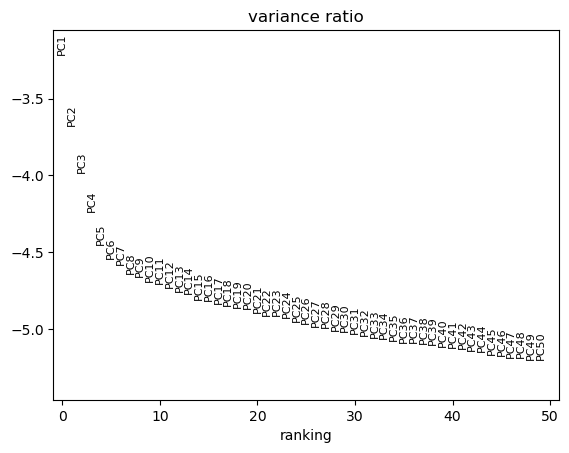

In [35]:
# -----------------------------------------------------------------------
# normalization 
sc.pp.normalize_total(adata)
# Logarithmize
sc.pp.log1p(adata)
# find highly variable genes
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor='seurat_v3')
# save original AnnData to `.raw` attribute
adata.raw = adata
# only keeping highly variable genes in AnnData
adata = adata[:, adata.var.highly_variable]
# scale each gene to unit variance
sc.pp.scale(adata)
# -----------------------------------------------------------------------
# run PCA
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
# run harmonoy
sce.pp.harmony_integrate(adata, 'batch')

adata.obsm['X_pca_raw'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
# -----------------------------------------------------------------------
# plot single PCs to the total variance in the data
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

## arguments selection

In [44]:
args_res = deque()
all_pcs = np.linspace(5, 20, 16).astype(int)
all_reses = np.linspace(0.1, 0.9, 5)

count = 0
total_process = len(all_pcs) * len(all_reses)
for pcs in all_pcs:
    for res in all_reses:
        count += 1

        sil = cal_clust_silhouette(adata, pcs, res)
        args_res.append([pcs, res, sil])

        if count % 3 == 0:
            print(f'Processing {count}/{total_process}')
        
args_res_df = pd.DataFrame(args_res, columns=['n_pcs', 'resolution', 'silhouette_score'])

Processing 3/80
Processing 6/80
Processing 9/80
Processing 12/80
Processing 15/80
Processing 18/80
Processing 21/80
Processing 24/80
Processing 27/80
Processing 30/80
Processing 33/80
Processing 36/80
Processing 39/80
Processing 42/80
Processing 45/80
Processing 48/80
Processing 51/80
Processing 54/80
Processing 57/80
Processing 60/80
Processing 63/80
Processing 66/80
Processing 69/80
Processing 72/80
Processing 75/80
Processing 78/80


In [45]:
best_args = args_res_df[args_res_df['silhouette_score'] == args_res_df['silhouette_score'].max()]
best_args

,n_pcs,resolution,silhouette_score
5,6,0.1,0.038122


In [46]:
args_res_df.to_csv('./3.cluster3.arg_select.csv', index=False)

/tmp/ipykernel_107019/147869129.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  adata = sc.pp.neighbors(adata, n_pcs=int(best_args['n_pcs']), copy=True)
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/public21/home/sc90258/miniconda

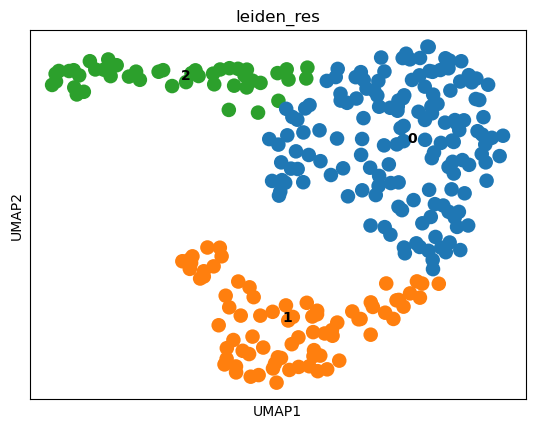

In [50]:
# plot PCA
adata = sc.pp.neighbors(adata, n_pcs=int(best_args['n_pcs']), copy=True)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_res", resolution=float(best_args['resolution']))

sc.pl.umap(
    adata,
    color=["leiden_res"],
    legend_loc="on data",
)

In [20]:
marker_genes = {
    'cardia': ['AAEL004522'], # gambicin
    'VM': ['AAEL001673'], # Actin
}

In [21]:
adata = sc.read('./3.cluster3.Annotation.h5ad')

Only considering the two last: ['.Annotation', '.h5ad'].
Only considering the two last: ['.Annotation', '.h5ad'].


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/categorical.py:641: F

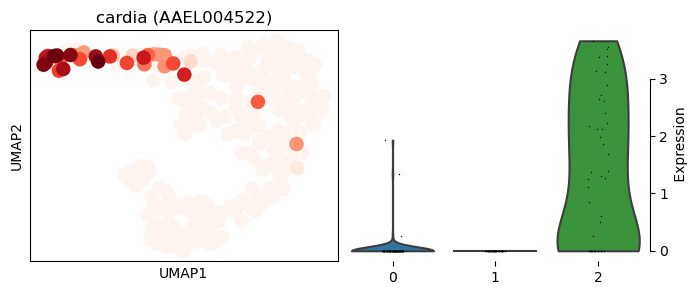

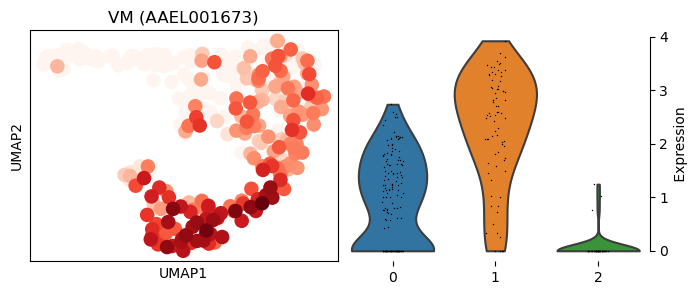

In [22]:
def plot_umap_violin_rep(adata, marker, cluster):

    import matplotlib.pyplot as plt
    import seaborn as sns

    fig = plt.figure(figsize=(8, 3))

    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    sc.pl.umap(
        adata,
        color=marker,
        vmax='p99.8',
        vmin=0,
        frameon=True,
        cmap="Reds",
        colorbar_loc=None,
        title=f'{cluster} ({marker})',
        ax=ax1, show=False
    )

    # ax1.arrow(
    #     -6.5, -3, 0, 3, 
    #     width=0.01, head_width=0.2, overhang=0.3, 
    #     color='k', zorder=10)
    # ax1.arrow(
    #     -6.5, -3, 3, 0, 
    #     width=0.01, head_width=0.2, overhang=0.3,
    #     color='k', zorder=10)

    # ax1.text(-3.1, -3, 'UMAP-1', ha='left', va='center', fontsize=8)
    # ax1.text(-6.5, 0.8, 'UMAP-2', ha='center', va='bottom', rotation=90, fontsize=8)

    # ax1.set_title('')
    # ax1.set_xlabel('')
    # ax1.set_ylabel('')

    # ax1.set_xlim(-7.5, 21)
    # ax1.set_ylim(-3.6, 16)

    sc.pl.violin(
        adata,
        marker,
        groupby='leiden_res',
        ax=ax2, show=False
    )

    ax2.set_xlabel('')

    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel(' Expression')
    ax2.tick_params(axis='y', right=True)
    sns.despine(top=True, bottom=True, left=True, right=False, trim=1, ax=ax2)

    # plot title
    # ax1.plot((-6.5, 50), (19,19), '-k', clip_on=False, zorder=100)
    # ax1.text((-6.5 + 50) / 2, 19.2, f'{cluster} ({marker})', ha='center', va='bottom')

    plt.subplots_adjust(
        hspace=0.3, wspace=0.01)

for cluster in marker_genes.keys():
    for marker in marker_genes[cluster]:

        plot_umap_violin_rep(
            adata, marker, cluster, 
        )

In [54]:
# save data
adata.write("3.cluster3.Annotation.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 274 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'batch', 'leiden_res'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-rep1', 'mean_counts-rep1', 'pct_dropout_by_counts-rep1', 'total_counts-rep1', 'n_cells_by_counts-rep2', 'mean_counts-rep2', 'pct_dropout_by_counts-rep2', 'total_counts-rep2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_res_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'